<a href="https://colab.research.google.com/github/yuanjinren/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/YuanjinRen_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df.shape

(421, 59)

In [0]:
df.head(5)

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
#Do train/validate/test split. 
#Train on reviews from 2016 & earlier. 
#Validate on 2017
#Test on 2018 & later.
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
train = df[df['Date']<'2017-01-01']
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'] > '2018-01-01']
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

In [0]:
#Begin with baselines for classification
target = 'Great'
y_train = train[target]

In [0]:
majority_class = y_train.mode()[0]  # majority class in training set is 'Not Great'
majority_class

False

In [0]:
y_train_pred = [majority_class] * len(y_train)

In [0]:
from sklearn.metrics import accuracy_score, mean_absolute_error
accuracy_score(y_train, y_train_pred)

0.5906040268456376

In [0]:
y_val = val[target]
y_val_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_val_pred)

0.5529411764705883

In [0]:
y_test = test[target]
y_test_pred = [majority_class] * len(y_test)
accuracy_score(y_test, y_test_pred)

0.42105263157894735

In [0]:
#Use scikit-learn for logistic regression
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

In [0]:
features = ['Yelp', 'Tortilla','Fillings', 'Cost', 'Cheese','Lobster', 'Avocado']   
# pick 7 features to do the following prediction
X_train = train[features]
X_val = val[features]
X_test = test[features]
X_train.shape, X_val.shape, X_test.shape

((298, 7), (85, 7), (38, 7))

In [0]:
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_val_enc = encoder.transform(X_val)
X_test_enc = encoder.transform(X_test)
X_train_enc.shape, X_val_enc.shape, X_test_enc.shape

((298, 11), (85, 11), (38, 11))

In [0]:
X_train_enc.head()

,Yelp,Tortilla,Fillings,Cost,Cheese_x,Cheese_nan,Cheese_X,Lobster_nan,Lobster_x,Avocado_nan,Avocado_x
0,3.5,3.0,3.5,6.49,1,0,0,1,0,1,0
1,3.5,2.0,2.5,5.45,1,0,0,1,0,1,0
2,NaN,3.0,3.0,4.85,0,1,0,1,0,1,0
3,NaN,3.0,3.0,5.25,0,1,0,1,0,1,0
4,4.0,4.0,3.5,6.59,1,0,0,1,0,1,0


In [0]:
imputer = SimpleImputer()
X_train_imp = imputer.fit_transform(X_train_enc)
X_val_imp = imputer.transform(X_val_enc)
X_test_imp = imputer.transform(X_test_enc)
X_train_imp.shape, X_val_imp.shape, X_test_imp.shape

((298, 11), (85, 11), (38, 11))

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_val_sc = scaler.transform(X_val_imp)
X_test_sc = scaler.transform(X_test_imp)

In [0]:
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train_enc.columns)
X_val_sc = pd.DataFrame(X_val_sc,columns=X_val_enc.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns= X_test_enc.columns)

In [0]:
X_train_sc.head()

,Yelp,Tortilla,Fillings,Cost,Cheese_x,Cheese_nan,Cheese_X,Lobster_nan,Lobster_x,Avocado_nan,Avocado_x
0,-1.712002e+00,-0.593162,-0.022447,-0.339805,1.209467,-1.0,-0.322031,0.058026,-0.058026,0.213574,-0.213574
1,-1.712002e+00,-1.849023,-1.202403,-1.208571,1.209467,-1.0,-0.322031,0.058026,-0.058026,0.213574,-0.213574
2,1.914185e-15,-0.593162,-0.612425,-1.709783,-0.826811,1.0,-0.322031,0.058026,-0.058026,0.213574,-0.213574
3,1.914185e-15,-0.593162,-0.612425,-1.375642,-0.826811,1.0,-0.322031,0.058026,-0.058026,0.213574,-0.213574
4,4.431779e-01,0.662698,-0.022447,-0.256270,1.209467,-1.0,-0.322031,0.058026,-0.058026,0.213574,-0.213574


In [0]:
model = LogisticRegression()
model.fit(X_train_sc, y_train)
y_mval_pred = model.predict(X_val_sc)
y_mtest_pred = model.predict(X_test_sc)
print(f'Validation accuracy: {accuracy_score(y_val,y_mval_pred)}')   # validation set accuracy
print(f'Test accuracy: {accuracy_score(y_test, y_mtest_pred)}')      # testing set accuracy

Validation accuracy: 0.8117647058823529
Test accuracy: 0.6578947368421053


In [0]:
# plot coefficients
coefs = model.coef_[0]
coefs = pd.Series(coefs, X_train_sc.columns)
coefs

Yelp           0.039917
Tortilla       0.762668
Fillings       1.642984
Cost           0.430857
Cheese_x       0.120137
Cheese_nan     0.101587
Cheese_X      -0.376291
Lobster_nan    0.116835
Lobster_x     -0.116835
Avocado_nan    0.270472
Avocado_x     -0.270472
dtype: float64

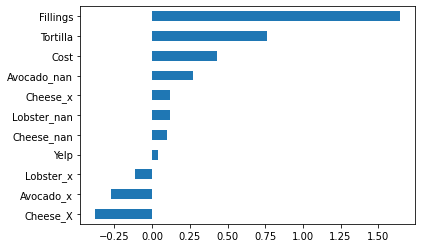

In [0]:
coefs.sort_values().plot.barh();

In [0]:
# show final test result
test

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
390,Asada,2018-04-04,NaN,NaN,NaN,7.20,3.0,NaN,NaN,24.50,22.7,1.00,4.0,5.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
391,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.0,NaN,NaN,20.00,23.0,0.84,3.5,5.0,4.3,3.5,5.0,4.0,3.0,3.8,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
392,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.5,NaN,NaN,17.50,24.0,0.80,4.0,4.5,5.0,4.5,5.0,4.0,4.0,4.5,4.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
393,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,2.0,NaN,NaN,19.00,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
394,California,2018-04-14,NaN,NaN,NaN,8.99,4.0,NaN,NaN,25.00,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
result = test[['Burrito','Date']].copy()
result

,Burrito,Date
77,California,2026-04-25
386,California,2018-01-02
387,Other,2018-01-09
388,California,2018-01-12
389,Other,2018-01-12
390,Asada,2018-04-04
391,Carnitas,2018-04-09
392,Carnitas,2018-04-09
393,Carnitas,2018-04-09
394,California,2018-04-14


In [0]:
result['Great'] = y_mtest_pred
result

,Burrito,Date,Great
77,California,2026-04-25,True
386,California,2018-01-02,True
387,Other,2018-01-09,False
388,California,2018-01-12,True
389,Other,2018-01-12,True
390,Asada,2018-04-04,False
391,Carnitas,2018-04-09,False
392,Carnitas,2018-04-09,True
393,Carnitas,2018-04-09,False
394,California,2018-04-14,True
